In [1]:
# (2) tidyverseの読み出し
library("tidyverse")
library("broom")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter(

In [2]:
# (3) データの読み込み
email_data <- read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
# (4) 女性向けメールが配信されたデータを削除したデータを作成
male_df <- email_data %>%
  filter(segment != "Womens E-Mail") %>% # 女性向けメールが配信されたデータを削除
  mutate(treatment = ifelse(segment == "Mens E-Mail", 1, 0)) # 介入を表すtreatment変数を追加
male_df |> head()


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  recency = col_double(),
  history_segment = col_character(),
  history = col_double(),
  mens = col_double(),
  womens = col_double(),
  zip_code = col_character(),
  newbie = col_double(),
  channel = col_character(),
  segment = col_character(),
  visit = col_double(),
  conversion = col_double(),
  spend = col_double()
)




recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0,0
9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0,1
9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0,1
2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0,1
4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0,0
3,1) $0 - $100,58.13,1,0,Urban,1,Web,No E-Mail,1,0,0,0


In [3]:
# (5) セレクションバイアスのあるデータを作成 #前と同じ
## seedを固定する
set.seed(1)

## 条件に反応するサンプルの量を半分にする
obs_rate_c <- 0.5
obs_rate_t <- 0.5

## バイアスのあるデータを作成
biased_data <- male_df %>%
  mutate(obs_rate_c = ifelse( (history > 300) | (recency < 6) | (channel == "Multichannel"), obs_rate_c, 1),
         obs_rate_t = ifelse( (history > 300) | (recency < 6) | (channel == "Multichannel"), 1, obs_rate_t),
         random_number = runif(n = NROW(male_df))) %>%
  filter( (treatment == 0 & random_number < obs_rate_c ) |
            (treatment == 1 & random_number < obs_rate_t) )

In [4]:
# (6) 傾向スコアの推定
ps_model <- glm(data = biased_data,
                formula = treatment ~ recency + history + channel,
                family = binomial)
ps_model |> tidy() #モデルの中身 特に意味はない

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.057584623,4.996185e-02,21.167845,1.890031e-99
recency,-0.126978534,3.448643e-03,-36.819855,8.884703e-297
history,0.000569505,5.450656e-05,10.448375,1.490577e-25
channelPhone,-0.343353320,4.247060e-02,-8.084494,6.242263e-16
channelWeb,-0.317944195,4.241573e-02,-7.495903,6.584333e-14


In [5]:
# (7) 傾向スコアマッチング
## ライブラリの読み込み
library("MatchIt")

## 傾向スコアを利用したマッチング
# matchitの中で傾向スコアも計算してくれるのかな...
# distance = "glm",という引数があったのでそうっぽい
m_near <- matchit(formula = treatment ~ recency + history + channel,
                  data = biased_data,
                  method = "nearest",
                  replace = TRUE)


In [6]:
## マッチング後のデータを作成
matched_data <- match.data(m_near)
dim(biased_data)
dim(matched_data) #マッチングで近い傾向スコアのサンプルを持ってきただけか

[1] 31863    16

[1] 24222    18

In [7]:
## マッチング後のデータで効果の推定
PSM_result <- lm(data = matched_data,
                 formula = spend ~ treatment) %>%
  tidy()
PSM_result #効果量は0.9程度という結果に #真の効果量が0.77程度なのでバイアスがかかっているように見えるが、この手法は |z=1の効果量を求めていることに注意

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.6201651,0.1987379,3.120517,0.0018074588
treatment,0.9075875,0.2358559,3.848059,0.0001193629


In [8]:
# (8) 逆確率重み付き推定（IPW）
## ライブラリの読み込み
library("WeightIt")

## 重みの推定
# これも勝手に傾向スコアの計算はしてくれるのかな... ドキュメントに見つからないけど
# method="ps" が propensity score weighting (傾向スコア重み付け)を表してた
weighting <- weightit(treatment ~ recency + history + channel,
              data = biased_data,
              method = "ps",
              estimand = "ATE")

In [9]:
## 重み付きデータでの効果の推定
IPW_result <- lm(data = biased_data,
                 formula = spend ~ treatment,
                 weights = weighting$weights) %>% #ここで重み付けをやってる
  tidy()
IPW_result #真の効果量が0.77程度なのでちょっとミスってる...

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.5804785,0.1162855,4.991840,6.012178e-07
treatment,0.8697003,0.1649628,5.272099,1.357499e-07


傾向スコアの良さは共変量のバランスを見ることでわかる

In [10]:
# (9) 共変量のバランスを確認
##ライブラリの読み込み
library("cobalt")

 cobalt (Version 4.3.1, Build Date: 2021-03-30 09:50:18 UTC)


Attaching package: ‘cobalt’


The following object is masked from ‘package:MatchIt’:

    lalonde




Warning message:
“Standardized mean differences and raw mean differences are present in the same plot. 
Use the 'stars' argument to distinguish between them and appropriately label the x-axis.”


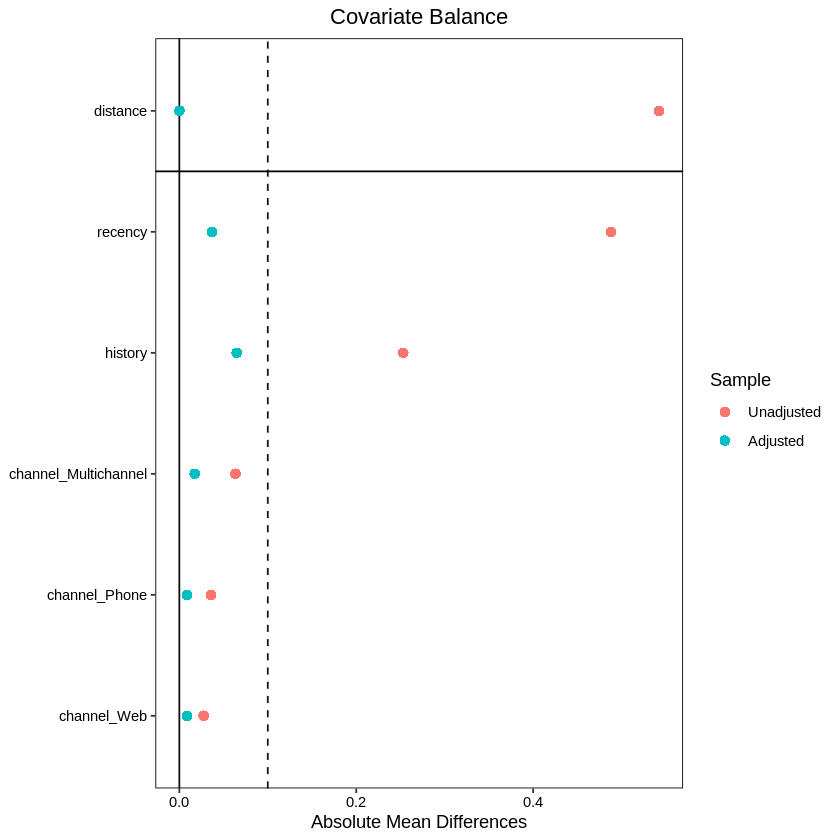

In [11]:
## マッチングしたデータでの共変量のバランス
love.plot(m_near, # このobjectを投げるだけで書ける...
          abs=TRUE,
          threshold = .1)
# 各特徴量の平均に対して、2群間で差を求め絶対値で示している。点が0に近いほど2群間の差が小さい。
# 傾向スコアで調整したほうが2群間でバランスが取れていることが確認できる。

Warning message:
“Standardized mean differences and raw mean differences are present in the same plot. 
Use the 'stars' argument to distinguish between them and appropriately label the x-axis.”


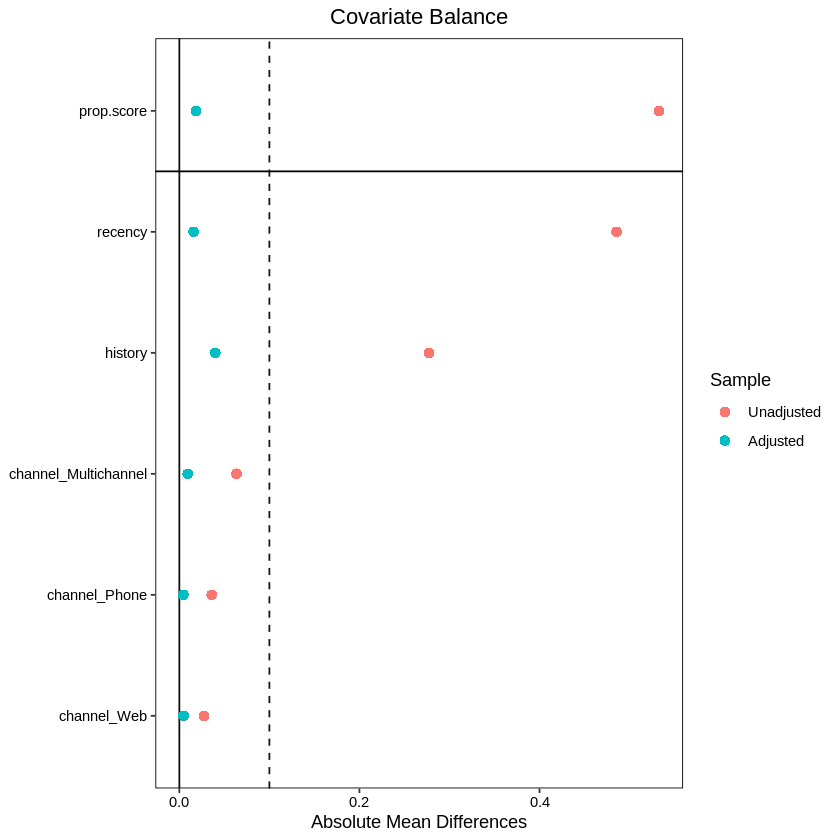

In [12]:
## 重み付きデータでの共変量のバランス
love.plot(weighting,
          abs=TRUE,
          threshold = .1)

機械学習を利用したメールマーケティグ施策の効果測定

In [13]:
# (10) 統計モデルを用いたメールの配信のログを分析
## まずはデータの作成
## 学習データと配信ログを作るデータに分割
set.seed(1)

train_flag <- sample(NROW(male_df), NROW(male_df)/2, replace = FALSE) #半分をtrainにする

# 機械学習のいつものようにtrainとtestに分割
male_df_train <- male_df[train_flag,] %>%
  filter(treatment == 0) #なんでtreatmentを0に限定してるんだろう... 学習できなくね？
# →これでいい。treatmentがない場合に売上が発生する確率を知りたい。すべては偏ったデータを作るため

male_df_test <- male_df[-train_flag,]

In [14]:
## 売上が発生する確率を予測するモデルを作成
predict_model <- glm(data = male_df_train,
                     formula = conversion ~ recency + history_segment +
                       channel + zip_code,
                     family = binomial)

In [15]:
## 売上の発生確率からメールの配信確率を決める
pred_cv <- predict(predict_model,
                   newdata = male_df_test,
                   type = "response")
pred_cv_rank <- percent_rank(pred_cv)


pred_cv |> 
    tidy() |>
    mutate(pred_cv_rank) |>
    mutate(pred_cv) |>
    select(names, pred_cv, pred_cv_rank) |>
    head()

# 配信確率とquantile

Warning message:
“'tidy.numeric' is deprecated.
See help("Deprecated")”
Warning message:
“`data_frame()` was deprecated in tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


names,pred_cv,pred_cv_rank
<chr>,<dbl>,<dbl>
1,0.006670530,0.7060452
2,0.002842313,0.3430489
3,0.001973488,0.2200319
4,0.001583054,0.1377546
5,0.006850794,0.7201727
6,0.005237747,0.6050408


In [16]:
## 配信確率を元にメールの配信を決める
set.seed(1)
mail_assign <- sapply(pred_cv_rank, rbinom, n = 1, size = 1) #forの記述を省略してる感じ

## 配信ログを作成
ml_male_df <- male_df_test %>%
  mutate(mail_assign = mail_assign, #mail_assign 列を作る
         ps = pred_cv_rank) %>%
  filter( (treatment == 1 & mail_assign == 1) |
            (treatment == 0 & mail_assign == 0)) #辻褄が悪いデータは消す

ml_male_df |> head()

recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,mail_assign,ps
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0,1,1,0.70604525
2,2) $100 - $200,118.40,1,0,Surburban,0,Web,Mens E-Mail,1,0,0,1,1,0.72017272
2,1) $0 - $100,29.99,0,1,Urban,1,Phone,No E-Mail,0,0,0,0,0,0.60504083
9,3) $200 - $350,334.24,1,0,Urban,0,Web,Mens E-Mail,0,0,0,1,1,0.61198723
3,1) $0 - $100,99.23,1,0,Rural,0,Web,Mens E-Mail,1,0,0,1,1,0.80423355
11,1) $0 - $100,53.81,1,0,Urban,1,Phone,No E-Mail,0,0,0,0,0,0.03323008


In [17]:
## RCTで実験をしていた場合の平均の差を確認
rct_male_lm <- lm(data = male_df_test, formula = spend ~ treatment) %>%
  tidy()

## 平均の比較
ml_male_lm <- lm(data = ml_male_df, formula = spend ~ treatment) %>%
  tidy()

rct_male_lm #真の結果
ml_male_lm #バイアスありの結果
# バイアスのせいで効果量が大きく見積もられている

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.6417370,0.1465706,4.378347,1.201525e-05
treatment,0.7636348,0.2074234,3.681527,2.324132e-04


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.6345635,0.2320336,2.734792,0.0062522270
treatment,1.1759645,0.3305735,3.557347,0.0003762366


In [18]:
## 傾向スコアマッチングの推定(TPS)
library(Matching)
PSM_result <- Match(Y = ml_male_df$spend,
                    Tr = ml_male_df$treatment,
                    X = ml_male_df$ps, #すでにある傾向スコアを用いている
                    estimand = "ATT")

## 推定結果の表示
summary(PSM_result)
# 効果量は1.3程度で有意とは言えない結果と推定されている

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


## 
##  Matching (Version 4.9-9, Build Date: 2021-03-15)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##





Estimate...  1.3685 
AI SE......  0.87834 
T-stat.....  1.558 
p.val......  0.11922 

Original number of observations..............  10725 
Original number of treated obs...............  5284 
Matched number of observations...............  5284 
Matched number of observations  (unweighted).  89145 



In [19]:
## IPWの推定
W.out <- weightit(treatment ~ recency + history_segment +
                    channel + zip_code,
                  data = ml_male_df,
                  ps = ml_male_df$ps,
                  method = "ps",
                  estimand = "ATE")

## 重みづけしたデータでの効果の分析
IPW_result <- ml_male_df %>%
  lm(data = .,
     spend ~ treatment,
     weights = W.out$weights) %>%
  tidy()

IPW_result #効果料は0.9程度と推定されている #p値も有意とのこと

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.5840008,0.2251939,2.593325,0.009518215
treatment,0.9142939,0.3195299,2.861372,0.004226274


Warning message:
“Standardized mean differences and raw mean differences are present in the same plot. 
Use the 'stars' argument to distinguish between them and appropriately label the x-axis.”


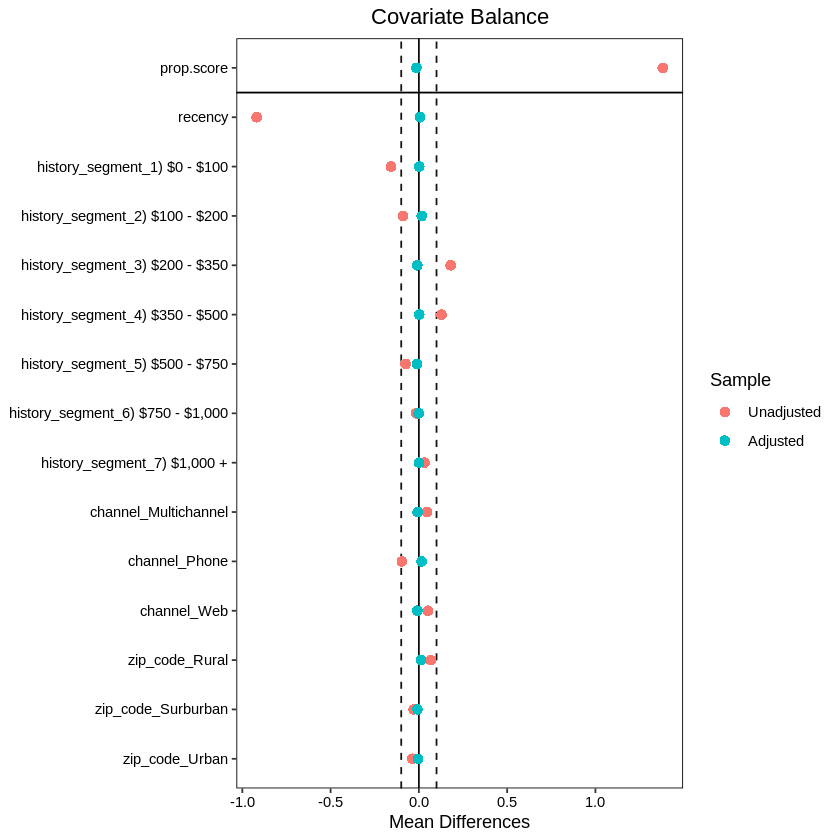

In [20]:
## 重み付けしたデータでの共変量のバランスを確認
love.plot(W.out,
          threshold = .1)
# バランスはある程度良くなっていることが確認できる